In [16]:
from pymatgen import Structure, Element, Specie
from pymatgen.core.structure import SiteCollection
from pymatgen.core.lattice import Lattice
from pymatgen.analysis.local_env import *
from pymatgen.io.vasp.outputs import Locpot, VolumetricData
import os
import math
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('once')

## Matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['figure.figsize'] = (7.0,6.0)
mpl.rcParams.update({'font.size': 18})


def cart_displacements(start, end, elements, max_disp=0.1, csv_fname='cart_displacements.txt'):
    """
    gives a text file with all the cartesian displacements of atoms

    Args:
        start (str): initial structure
        end (str): final structure
        elements (list): list of elements in the structure e.g. ['Y', 'Ti', 'O', 'S']
        max_disp (float): maximum displacement shown, default 0.1 Å
        csv_fname (str): filename of the csv file
    Returns:
        text file w displacements

    """

    start_struc = Structure.from_file(start)
    end_struc = Structure.from_file(end)

    el_dict = {i : 1 for i in elements}
    site_labels = []

    for site in start_struc:
        symbol = site.specie.symbol
        site_labels.append((symbol,el_dict[symbol]))
        el_dict[symbol] +=1
    start_struc.add_site_property('', site_labels)

    start_struc = start_struc.cart_coords
    end_struc = end_struc.cart_coords

    disp_list = []

    for n, (start_coord, end_coord) in enumerate(zip(start_struc, end_struc)):
        xdisp = math.pow(start_coord[0] - end_coord[0], 2)
        ydisp = math.pow(start_coord[1] - end_coord[1], 2)
        zdisp = math.pow(start_coord[2] - end_coord[2], 2)
        d = math.sqrt(xdisp + ydisp + zdisp)
        label = site_labels[n]
        if d >= max_disp:
            disp_list.append({'site': n+1,
                             'atom': label,
                             'displacement': f"{d: .3f}"})

    df = pd.DataFrame(disp_list)
    df.to_csv(csv_fname, header = True, index = False, sep='\t', mode='w')


def slab_thickness(start, start_zmax=None, end=None, end_zmax=None):
    """
    finds the thickness of the slab in c-direction based on the difference between the maximum and minimum cartesian coordinates of the slab
    allows for slab thickness comparison between the bulk-like and relaxed/reconstructed surface slab by setting end to final structure filename
    Args:
        start (str): intial structure filename
        start_zmax (float): the cartesian coordinate of the maximum coordinate in c-direction, used if the slab was not centred and some atoms moved to the other side of the unit cell; default: None
        end (str): end structure filename, default: None
        end_zmax (float): the cartesian coordinate of the maximum coordinate in c-direction, used if the slab was not centred and some atoms moved to the other side of the unit cell; default: None
    Returns
        prints slab thickness to terminal 
    """
    start_struc = Structure.from_file(start)
    start_struc = start_struc.cart_coords

    #just one slab
    if end is None and start_zmax is None:
        s_xmax, s_ymax, s_zmax = start_struc.max(axis = 0)
        s_xmin, s_ymin, s_zmin = start_struc.min(axis = 0)

        thickness = s_zmax - s_zmin

        print('the slab thickness is {:.3f} Å'.format(thickness))

    #one slab with specified max cartesian coordinate in z     
    elif end is None and start_zmax is not None: 
        s_xmax, s_ymax, s_zmax = start_struc.max(axis = 0)
        s_xmin, s_ymin, s_zmin = start_struc.min(axis = 0)

        thickness = start_zmax - s_zmin

        print('the slab thickness is {:.3f} Å'.format(thickness))

    #initial and relaxed structures, no spefcified max coords
    elif end_zmax is None:
        end_struc = Structure.from_file(end)
        end_struc = end_struc.cart_coords

        s_xmax, s_ymax, s_zmax = start_struc.max(axis = 0)
        s_xmin, s_ymin, s_zmin = start_struc.min(axis = 0)
        e_xmax, e_ymax, e_zmax = end_struc.max(axis = 0)
        e_xmin, e_ymin, e_zmin = end_struc.min(axis = 0)

        start_thickness = s_zmax - s_zmin
        end_thickness = e_zmax - e_zmin
        difference = start_thickness - end_thickness

        print('the initial slab thickness is {:.3f} Å. the final slab thickness is {:.3f} Å and the difference between the two is {:.3f} Å'.format(start_thickness, end_thickness, difference))

    #intial and relaxed structure, specified max coord 
    else:
        end_struc = Structure.from_file(end)
        end_struc = end_struc.cart_coords

        s_xmax, s_ymax, s_zmax = start_struc.max(axis = 0)
        s_xmin, s_ymin, s_zmin = start_struc.min(axis = 0)

        e_xmin, e_ymin, e_zmin = end_struc.min(axis = 0)

        start_thickness = s_zmax - s_zmin
        end_thickness = end_zmax - e_zmin
        difference = start_thickness - end_thickness

        print('the initial slab thickness is {:.3f} Å. the final slab thickness is {:.3f} Å. the difference between the two is {:.3f} Å'.format(start_thickness, end_thickness, difference))
def bond_analysis(structure, atoms, nn_method=VoronoiNN(tol=0.1, cutoff=10)):
    """
    parses the structure looking for bonds between atoms
    Args:
        structure (str): filename 
        atoms (list of tuples): list of bonds to compare e.g. [('Y', 'O'), ('Ti', 'S')]
        nn_method (class): pymatgen.analysis.local_env nearest neighbour method to use to find the coordination environment
    Returns:
        csv file
    """

    bonds_info = []
    struc = Structure.from_file(structure)
    struc.add_oxidation_state_by_guess()

    for n, pos in enumerate(struc):
        for atom1, atom2 in atoms:
            if pos.specie.symbol == atom1:
                nearest_neighbours =  nn_method.get_nn_info(struc, n)
                matched_sites = []
                for d in nearest_neighbours:
                    if d.get('site').specie.symbol == atom2:
                        matched_sites.append(d)
                bond_distances = [struc.get_distance(n,x['site_index']) for x in matched_sites]
                bonds_info.append({'{}_index'.format(atom1): n+1,
                                   '{}_c_coord'.format(atom1): pos.c,
                                   '{}-{}_bond_distance'.format(atom1,atom2): np.mean(bond_distances)})
    df = pd.DataFrame(bonds_info)
    df.to_csv('bond_analysis_data.csv', index=False)

def plot_bond_analysis(atoms, plt_fname='bond_analysis.png', **kwargs):
    """
    plots the bond distance graph thingie luisa introduced to the mix from the csv file generated with bond_analysis
    Args:
        atoms (list of tuples) in the same order as atoms in bond_analysis
        plt_fname (str): filename of the plot
    Returns:
        plot of bond distance change in c direction
    """

    df = pd.read_csv('bond_analysis_data.csv')
    colors = plt.rcParams["axes.prop_cycle"]()

    fig, axs = plt.subplots(len(atoms))

    i=0
    for atom1, atom2 in atoms:
        c = next(colors)["color"]
        x = df['{}_c_coord'.format(atom1)]
        y = df['{}-{}_bond_distance'.format(atom1,atom2)]
        axs[i].scatter(x, y, marker='x', color=c)
        axs[i].set_ylabel("Bond distance / Å ")
        axs[i].legend(['{}-{} bond'.format(atom1, atom2)])
        i+=1

    plt.xlabel("Fractional coordinates")
    plt.savefig(plt_fname)

def electrostatic_potential(lattice_vector, filename='./LOCPOT', axis=2, make_csv=True, csv_fname='potential.csv', plt_fname='potential.png', **kwargs):
    """
    reads LOCPOT to get the planar and macroscopic potential in specified direction
    Args:
        lattice_vector (float): the periodicity of the slab in the specified direction
        filename (str): path to your locpot file, default='./LOCPOT'
        axis (int): direction in which the potential is investigated; a=0, b=1, c=2; default=2
        make_csv (bool): makes a csv file with planar and macroscopic potential, default=True
        csv_fname (str): filename of the csv file, default='potential.csv'
        plt_fname (str): filename of the plot of potentials, controls the format, default='potential.png'
    Returns:
        plot of planar and macroscopic potential, csv file with both for your open science needs
    """
    #read potential and structure data
    lpt = Locpot.from_file(filename)
    struc = Structure.from_file(filename)

    #planar potential
    planar = lpt.get_average_along_axis(axis)

    #divide lattice parameter by no. of grid points in the direction
    resolution = struc.lattice.abc[axis]/lpt.dim[axis]

    #get number of points over which the rolling average is evaluated
    points = int(lattice_vector/resolution)

    #need extra points at the start and end of planar potential to evaluate the macroscopic potential
    #this makes use of the PBC where the end of one unit cell coincides with start of the next one
    add_to_start = planar[(len(planar) - points): ]
    add_to_end = planar[0:points]
    pfm_data = np.concatenate((add_to_start,planar,add_to_end))
    pfm = pd.DataFrame(data=pfm_data, columns=['y'])

    #macroscopic potential
    m_data = pfm.y.rolling(window=points, center=True).mean()
    macroscopic = m_data.iloc[points:(len(planar)+points)]
    macroscopic.reset_index(drop=True,inplace=True)

    #make csv
    if make_csv is True:
        data = pd.DataFrame(data=planar, columns=['planar'])
        data['macroscopic'] = macroscopic
        data.to_csv(csv_fname, header = True, index = False)

    #plot both planar and macroscopic, save figure
    fig,ax = plt.subplots()
    ax.plot(planar, label='planar')
    ax.plot(macroscopic, label='macroscopic')
    ax.legend()
    plt.ylabel('potential / eV')
    plt.savefig(plt_fname)


#this is still very much a work in progress, i cannot figure out how to make the fkcin nearest neighbour methods work and i am too scared to ask alex again lol
def nearest_neighbour(start, elements, end=None, nn_method=MinimumDistanceNN()):
    """

    Args:
        start (str):
        elements (list):
        end (str): default None
        nn_method :
    """

    start_struc = Structure.from_file(start)

    el_dict = {i : 1 for i in elements}
    site_labels = []

    for site in start_struc:
        symbol = site.specie.symbol
        site_labels.append((symbol,el_dict[symbol]))
        el_dict[symbol] +=1
    start_struc.add_site_property('', site_labels)

    #start_struc.merge_sites(tol=0.001)

    start_struc.add_oxidation_state_by_guess()


    if end is None:
        nn_list = []
        for n, site in enumerate(start_struc):
            cn_start = nn_method.get_cn(start_struc, n)
            label = site_labels[n]
            nn_list.append({'site': n+1,
                           'atom': label,
                           'cn start': cn_start})
        df = pd.DataFrame(nn_list)
        df.to_csv('nn_data.txt', header = True, index = False, sep='\t', mode='w')

    else:
        end_struc = Structure.from_file(end)
        end_struc.add_oxidation_state_by_guess()

        nn_list = []
        for n, waa in enumerate(start_struc):
            cn_start = nn_method.get_cn(start_struc, n)
            cn_end = nn_method.get_cn(end_struc, n)
            cn_diff = cn_end - cn_start
            label = site_labels[n]
            nn_list.append({'site': n+1,
                           'atom': label,
                           'cn start': cn_start,
                           'cn_end': cn_end,
                           'diff': cn_diff})
        df = pd.DataFrame(nn_list)
        df.to_csv('nn_data.txt', header = True, index = False, sep='\t', mode='w')





In [11]:
cart_displacements(start='./POSCAR_LTA_010', end='./CONTCAR_LTA_010', elements=['La','Ti','Ag','S','O'])

In [17]:
slab_thickness(start='POSCAR_LTA_010', end='./CONTCAR_LTA_010')

the initial slab thickness is 9.837 Å. the final slab thickness is 10.296 Å and the difference between the two is -0.458 Å


In [8]:
bond_analysis('./CONTCAR_LTA_010', atoms=[('Ti', 'O'), ('Ag', 'S')])

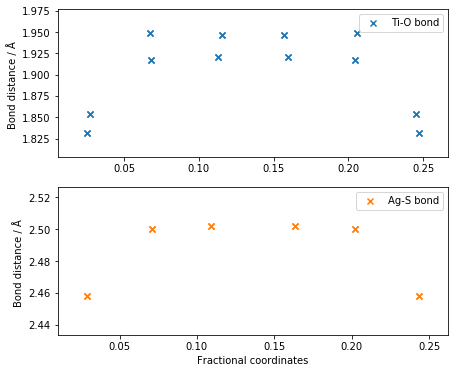

In [9]:
plot_bond_analysis([('Ti', 'O'), ('Ag', 'S')])

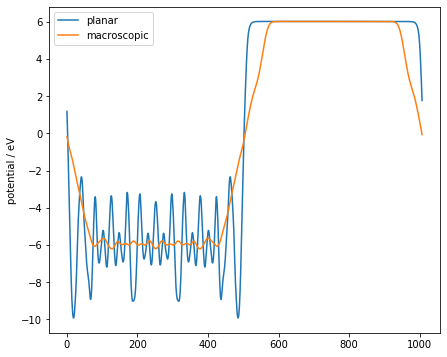

In [10]:
electrostatic_potential(lattice_vector=10, filename=r'./LOCPOT')